In [1]:
import gizmo_analysis as gizmo
import halo_analysis as halo
import matplotlib.pyplot as plt
import numpy as np
import utilities as ut
from astropy.io import ascii
from gc_utils import get_halo_tree, main_prog_halt  # noqa: F401
from scipy.optimize import minimize, minimize_scalar

In [2]:
sim = "m12i"
snapshot = 600

sim_dir = "../../../simulations/"
# sim_dir = "../../simulations/"
data_dir = "data/"
sim_codes = data_dir + "external/simulation_codes.json"

fire_dir = sim_dir + sim + "/" + sim + "_res7100/"

In [4]:
halt = get_halo_tree(sim, sim_dir)

Retrieving Halo Tree.....................: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


In [3]:
snap_lst = np.linspace(10, 600, 591, dtype=int)
hals = halo.io.IO.read_catalogs("index", snap_lst, fire_dir)


# in utilities.simulation.Snapshot():
* reading:  simulations/m12i/m12i_res7100/snapshot_times.txt

* using snapshot indices = [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 

In [5]:
main_halo_tid = 25236877
tid_main_lst = main_prog_halt(halt, main_halo_tid)

In [11]:
all_snapshot_fil = "/Users/z5114326/Documents/simulations/m12i/m12i_res7100/snapshot_times.txt"
with open(all_snapshot_fil) as f:
    content = f.readlines()
    content = content[5:]
snap_all = ascii.read(content)["i"]
tim_all = ascii.read(content)["time[Gyr]"]
lbt_all = ascii.read(content)["lookback-time[Gyr]"]

In [64]:
prog_dict = {}

for tid in tid_main_lst:
    idx = np.where(halt["tid"] == tid)[0][0]
    prog_idx_lst = halt.prop("progenitor.indices", idx)
    snap = halt["snapshot"][idx]
    snap_prog = snap - 1

    prog_dict[str(snap_prog)] = {}

    prog_tid_lst = []
    prog_cid_lst = []
    prog_mass_lst = []
    prog_first_infall_snap_lst = []
    length_of_infall = []

    t_idx = np.where(snap_all == snap)[0][0]
    t_last = tim_all[t_idx]
    for prod_idx in prog_idx_lst:
        if halt["am.progenitor.main"][prod_idx] == 0:
            prog_tid_lst.append(halt["tid"][prod_idx])
            cid = halt["catalog.index"][prod_idx]
            prog_cid_lst.append(cid)
            prog_mass_lst.append(halt["mass"][prod_idx])
            infall_first_snap = hals[snap_prog]["infall.snapshot"][cid]
            prog_first_infall_snap_lst.append(infall_first_snap)

            t_idx = np.where(snap_all == infall_first_snap)[0][0]
            t_first = tim_all[t_idx]
            t_length = t_last - t_first
            length_of_infall.append(t_length)

            prog_dict[str(snap_prog)]["tid"] = prog_tid_lst
            prog_dict[str(snap_prog)]["cid"] = prog_cid_lst
            prog_dict[str(snap_prog)]["mass"] = prog_mass_lst
            prog_dict[str(snap_prog)]["first_infall"] = prog_first_infall_snap_lst
            prog_dict[str(snap_prog)]["length_of_infall"] = length_of_infall

In [65]:
average_legnth_lst = []
std_legnth_lst = []
time_lst = []

for snap_str in prog_dict.keys():
    if len(prog_dict[snap_str]) != 0:
        time_infall_lst = prog_dict[snap_str]["length_of_infall"]
        snap = int(snap_str) + 1

        t_idx = np.where(snap_all == snap)[0][0]
        time = tim_all[t_idx]
        time_lst.append(time)

        tim_avg = np.average(time_infall_lst)
        tim_std = np.std(time_infall_lst)

        average_legnth_lst.append(tim_avg)
        std_legnth_lst.append(tim_std)

Text(0, 0.5, 'Average Time From First \n Infall to Fully Accreted')

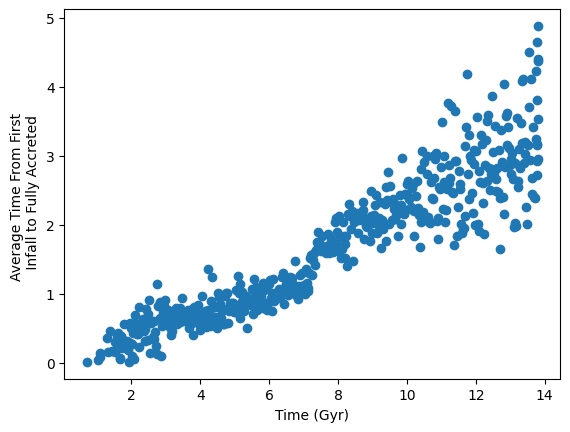

In [66]:
plt.scatter(time_lst, average_legnth_lst)
plt.xlabel("Time (Gyr)")
plt.ylabel("Average Time From First \n Infall to Fully Accreted")

In [30]:
mass_lst = []
time_lst = []

for snap_str in prog_dict.keys():
    if len(prog_dict[snap_str]) != 0:
        mass = np.sum(prog_dict[snap_str]["mass"])
        snap = int(snap_str) + 1

        t_idx = np.where(snap_all == snap)[0][0]
        time = tim_all[t_idx]
        time_lst.append(time)

        mass_lst.append(mass)

In [90]:
nbins = 28
bins = np.linspace(0, 14, nbins + 1)

time_bin = []
mass_bin_avg = []
for i in range(0, len(bins) - 1):
    time_bin.append(np.average((bins[i], bins[i + 1])))

    bin_mask = (bins[i] <= time_lst) & (time_lst < bins[i + 1])
    mass_bin_avg.append(np.nanmean(np.array(mass_lst)[bin_mask]))


/var/folders/nb/byfjq48d6jz8b3g74s3zr7rh0000gp/T/ipykernel_50398/599840465.py:10: RuntimeWarning: Mean of empty slice
  mass_bin_avg.append(np.nanmean(np.array(mass_lst)[bin_mask]))


Text(0.5, 0, 'Time (Gyr)')

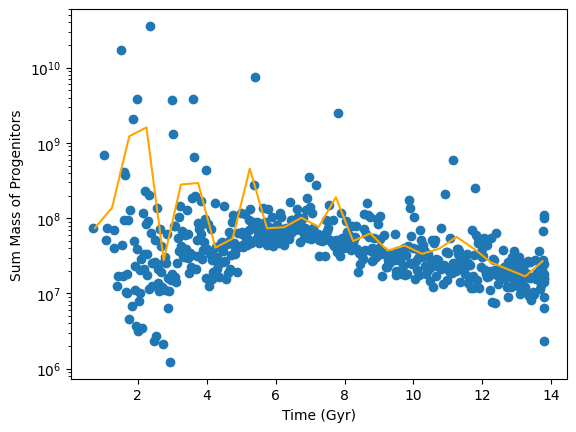

In [96]:
plt.scatter(time_lst, mass_lst)
plt.plot(time_bin, mass_bin_avg, c="orange")
plt.yscale("log")
plt.ylabel("Sum Mass of Progenitors")
plt.xlabel("Time (Gyr)")